<a href="https://colab.research.google.com/github/rukaiyafahmida/SoftComputing/blob/main/Assignment_02_170204004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import seaborn as sns
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df = pd.read_csv('/content/drive/MyDrive/4.2 Rukaiya/Dataset.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


#Preprossesing

In [39]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

seed = 4
torch.manual_seed(seed)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
def cleaner(text):
    text = text.lower()
    text=text[1:] 
    text = re.sub(urlPattern,'',text)
    text = text.translate(str.maketrans("","",string.punctuation))
    tokens = word_tokenize(text)
    final_tokens = [w for w in tokens if w not in stop_words]
    wordLemm = WordNetLemmatizer()
    final_words=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        final_words.append(word)
    return ' '.join(final_words)   

In [41]:
df['final_text'] = df['Text'].apply(lambda x: cleaner(x))

In [42]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [43]:
df = df.sample(frac = 1) 
df

,Text,Sentiment,final_text
1256,AAP just remember knees AND toes come after he...,0,ap remember knee toe come head shoulder
2444,AN rally on MS upgrade might be enough to keep...,1,rally m upgrade might enough keep u long price...
5338,JPMorgan Chase Chief Executive James Dimon ret...,1,pmorgan chase chief executive james dimon retu...
3178,"even more breakouts for YHOO , highest levels ...",1,ven breakout yhoo highest level since 2008 typ...
2220,ZNGA continuing rally,1,nga continuing rally
...,...,...,...
2360,user AAP will make computers in S. The 1st li...,0,ser aap make computer 1st line tablet called p...
4591,we are loving the upside movement on our CAI p...,1,loving upside movement cai position today grea...
960,long ACI 7.39,1,ong aci 739
655,user jmixer INO since Jan 7 it is a green week...,0,ser jmixer ino since jan green weekly closed l...


In [44]:
from sklearn.model_selection import train_test_split
x = df['final_text'].values
y = df['Sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [45]:
df.head()

,Text,Sentiment,final_text
1256,AAP just remember knees AND toes come after he...,0,ap remember knee toe come head shoulder
2444,AN rally on MS upgrade might be enough to keep...,1,rally m upgrade might enough keep u long price...
5338,JPMorgan Chase Chief Executive James Dimon ret...,1,pmorgan chase chief executive james dimon retu...
3178,"even more breakouts for YHOO , highest levels ...",1,ven breakout yhoo highest level since 2008 typ...
2220,ZNGA continuing rally,1,nga continuing rally


# One hot embedding

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [47]:
 from keras.preprocessing.text import Tokenizer
 tokenizer = Tokenizer()
 tokenizer.fit_on_texts(x_train)
 X_train = tokenizer.texts_to_sequences(x_train)
 X_test = tokenizer.texts_to_sequences(x_test)
 vocab_size = len(tokenizer.word_index)+1

In [48]:
 print(x_train[1])
 print(X_train[1]) 

nhod check weekly target previous low 2006
[2564, 268, 39, 46, 766, 44, 2565]


In [49]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [50]:
 from keras.preprocessing.sequence import pad_sequences
 maxlen = 1000
 X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
 X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [51]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras import layers 
import tensorflow as tf

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 200)         1863600   
                                                                 
 conv1d_4 (Conv1D)           (None, 999, 256)          102656    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 499, 256)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 497, 128)          98432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 248, 128)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 245, 64)          

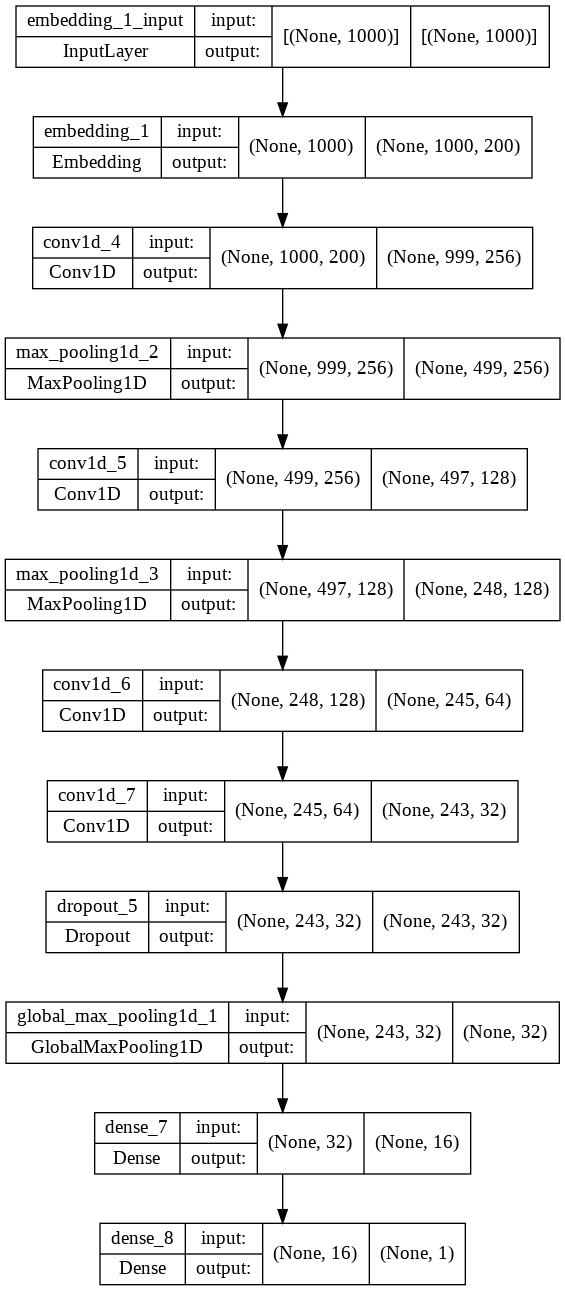

In [52]:
seed = 4
torch.manual_seed(seed)
embedding_dim = 200
cnnmodel = Sequential()
cnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
cnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
cnnmodel.add(layers.MaxPooling1D(pool_size = 2))
cnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
cnnmodel.add(layers.MaxPooling1D(pool_size = 2))
cnnmodel.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
cnnmodel.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cnnmodel.add(layers.Dropout(0.2))
cnnmodel.add(layers.GlobalMaxPooling1D())
cnnmodel.add(layers.Dense(16, activation='relu'))
cnnmodel.add(layers.Dense(1, activation='sigmoid'))
cnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
cnnmodel.summary() 

tf.keras.utils.plot_model(cnnmodel, show_shapes = True, show_layer_names = True)


In [53]:
history = cnnmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = cnnmodel.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy, f1_score, precision, recall = cnnmodel.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 9s 52ms/step - loss: 0.6307 - accuracy: 0.6546 - f1_m: 0.7775 - precision_m: 0.6605 - recall_m: 0.9681 - val_loss: 0.5554 - val_accuracy: 0.7299 - val_f1_m: 0.7940 - val_precision_m: 0.7381 - val_recall_m: 0.8691
Epoch 2/10
145/145 [==============================] - 7s 49ms/step - loss: 0.4009 - accuracy: 0.8331 - f1_m: 0.8681 - precision_m: 0.8637 - recall_m: 0.8800 - val_loss: 0.5352 - val_accuracy: 0.7532 - val_f1_m: 0.8154 - val_precision_m: 0.7460 - val_recall_m: 0.9104
Epoch 3/10
145/145 [==============================] - 7s 49ms/step - loss: 0.1649 - accuracy: 0.9426 - f1_m: 0.9542 - precision_m: 0.9555 - recall_m: 0.9550 - val_loss: 0.5859 - val_accuracy: 0.7498 - val_f1_m: 0.8038 - val_precision_m: 0.7787 - val_recall_m: 0.8372
Epoch 4/10
145/145 [==============================] - 7s 49ms/step - loss: 0.0622 - accuracy: 0.9793 - f1_m: 0.9837 - precision_m: 0.9850 - recall_m: 0.9832 - val_loss: 1.0974 - val_accuracy: 0.7377 

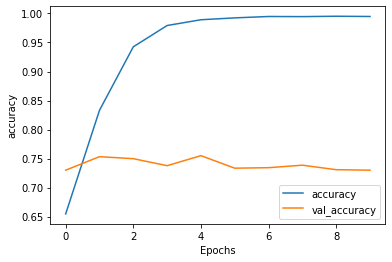

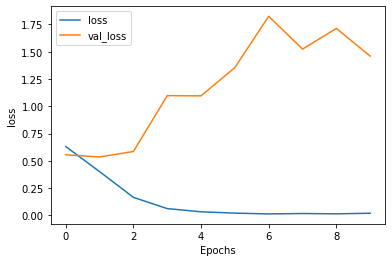

In [54]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Bag Of Words

In [55]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)


from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

vectorizer.fit(x)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [56]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [57]:
noOfFeature = X_test.shape[1]
print(noOfFeature)

10573


In [58]:
print('Total training data: ', X_train.shape[0])
print('Total testing data:  ', X_test.shape[0])

Total training data:  4632
Total testing data:   1159


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               2706944   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 16)               

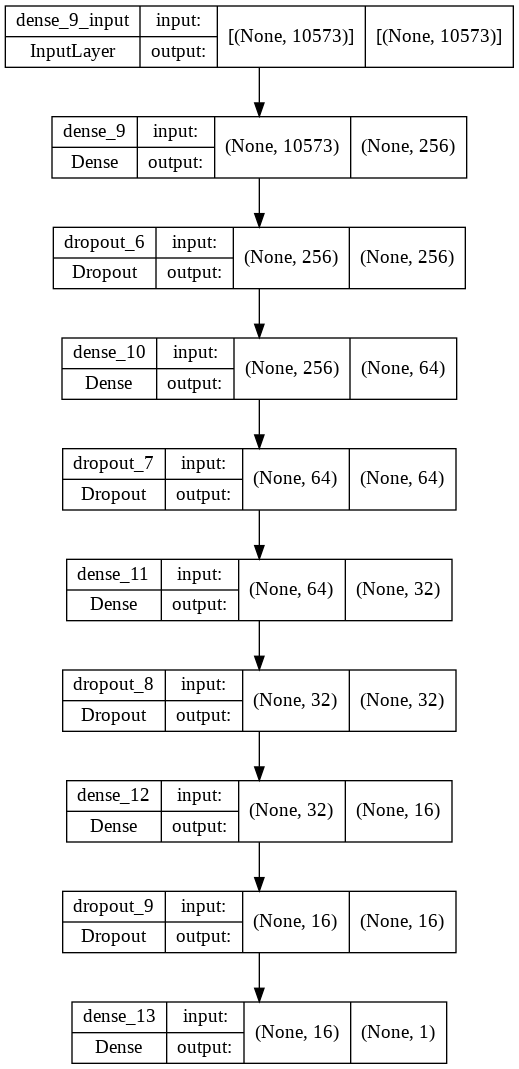

In [59]:
bogmodel = Sequential()
bogmodel.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=64, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=32, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=16, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=1, activation='sigmoid'))

bogmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
bogmodel.summary() 

tf.keras.utils.plot_model(bogmodel, show_shapes = True, show_layer_names = True)


In [60]:
history = bogmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = bogmodel.evaluate(X_train, y_train)
print("Training Accuracy: {}".format(accuracy))

loss, accuracy, f1_score, precision, recall = bogmodel.evaluate(X_test, y_test)
print("Testing Accuracy:  {}".format(accuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 3s 11ms/step - loss: 0.6046 - accuracy: 0.6550 - f1_m: 0.7752 - precision_m: 0.6618 - recall_m: 0.9542 - val_loss: 0.5182 - val_accuracy: 0.7645 - val_f1_m: 0.8200 - val_precision_m: 0.7726 - val_recall_m: 0.8817
Epoch 2/10
145/145 [==============================] - 1s 9ms/step - loss: 0.3384 - accuracy: 0.8700 - f1_m: 0.8957 - precision_m: 0.8948 - recall_m: 0.9038 - val_loss: 0.5264 - val_accuracy: 0.7688 - val_f1_m: 0.8096 - val_precision_m: 0.7994 - val_recall_m: 0.8285
Epoch 3/10
145/145 [==============================] - 1s 9ms/step - loss: 0.1138 - accuracy: 0.9629 - f1_m: 0.9701 - precision_m: 0.9720 - recall_m: 0.9698 - val_loss: 0.7407 - val_accuracy: 0.7601 - val_f1_m: 0.8028 - val_precision_m: 0.7947 - val_recall_m: 0.8196
Epoch 4/10
145/145 [==============================] - 1s 9ms/step - loss: 0.0274 - accuracy: 0.9920 - f1_m: 0.9937 - precision_m: 0.9941 - recall_m: 0.9936 - val_loss: 1.1562 - val_accuracy: 0.7506 - v

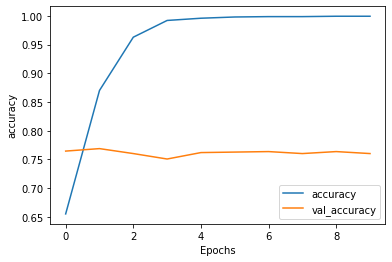

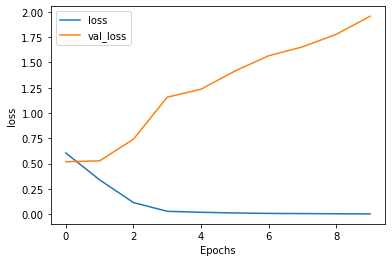

In [61]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# TF-IDF

In [62]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)


from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')

vectorizer.fit(x)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [63]:
X_train = X_train.toarray()
X_test = X_test.toarray()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               2706944   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)               

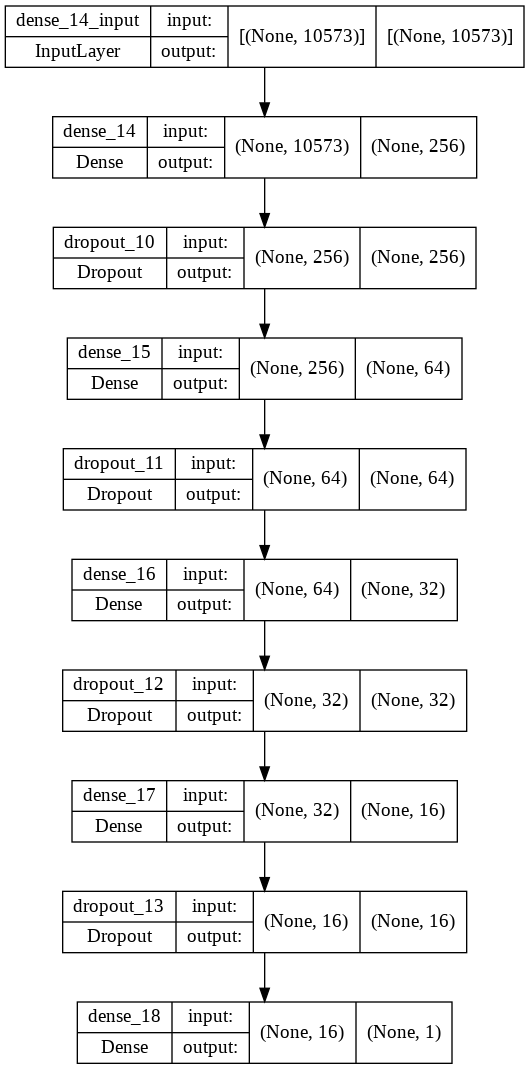

In [64]:
tfmodel = Sequential()
tfmodel.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=64, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=32, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=16, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=1, activation='sigmoid'))

tfmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
tfmodel.summary() 

tf.keras.utils.plot_model(tfmodel, show_shapes = True, show_layer_names = True)


In [65]:
history = tfmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = tfmodel.evaluate(X_train, y_train)
print("Training Accuracy: {}".format(accuracy))

loss, accuracy, f1_score, precision, recall = tfmodel.evaluate(X_test, y_test)
print("Testing Accuracy:  {}".format(accuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 3s 13ms/step - loss: 0.6082 - accuracy: 0.6561 - f1_m: 0.7644 - precision_m: 0.6803 - recall_m: 0.9039 - val_loss: 0.4947 - val_accuracy: 0.7610 - val_f1_m: 0.8133 - val_precision_m: 0.7720 - val_recall_m: 0.8663
Epoch 2/10
145/145 [==============================] - 2s 11ms/step - loss: 0.3379 - accuracy: 0.8713 - f1_m: 0.8977 - precision_m: 0.8976 - recall_m: 0.9046 - val_loss: 0.5194 - val_accuracy: 0.7575 - val_f1_m: 0.8137 - val_precision_m: 0.7694 - val_recall_m: 0.8714
Epoch 3/10
145/145 [==============================] - 1s 9ms/step - loss: 0.1028 - accuracy: 0.9676 - f1_m: 0.9742 - precision_m: 0.9737 - recall_m: 0.9763 - val_loss: 0.7900 - val_accuracy: 0.7662 - val_f1_m: 0.8192 - val_precision_m: 0.7925 - val_recall_m: 0.8569
Epoch 4/10
145/145 [==============================] - 1s 10ms/step - loss: 0.0302 - accuracy: 0.9924 - f1_m: 0.9943 - precision_m: 0.9934 - recall_m: 0.9956 - val_loss: 1.1015 - val_accuracy: 0.7653 -

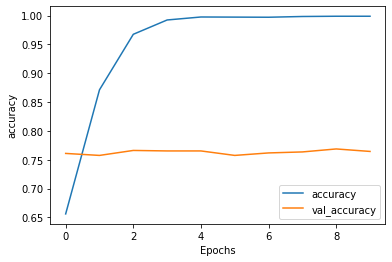

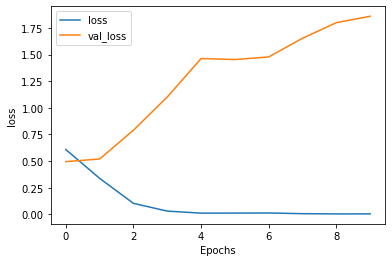

In [66]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')